In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import scipy
import os
from scipy.stats import linregress
from datetime import timedelta

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

plt.rcParams['figure.dpi'] = 300

## 1. Load in Data

In [2]:
# load in LAI ceptometer data
lai = pd.read_csv('C:/Users/jeanallen/Desktop/SHIFT_CWC/data/field_data/LAI_final.csv')

In [3]:
# load in CWC data
cwc_data_dir = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_1100_1300'

date_list = ['20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
datetime_list = [datetime.strptime(date, '%Y%m%d') for date in date_list]

# handling for non-convergence in the invert_liquid_water function
def kill_nans(df):
    mask = (df['CWC'] > 0.499962 - 0.0001) & (df['CWC'] < 0.499962 + 0.0001)
    df.loc[mask, 'CWC'] = np.nan
    return df

## first the full baloney of 850-1300nm
cwc_file_paths = [os.path.join(cwc_data_dir, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers
cwc = pd.read_csv(cwc_file_paths[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope']).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    cwc = cwc.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})
# now make a list of dataframes containing all the good stuff
cwc_df_list = []
for date, file_path in zip(date_list, cwc_file_paths):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df_list.append(cwc_df)

In [19]:
# Defining color cycle to correspond with dates, extended a lil to account for more dates
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_list.append('#000080')
color_list.append('#420303')
color_list.append('#018788')

## 2. Join CWC and LAI

In [69]:
# function that returns the LAI data for a given tree number
def get_springLAI(treenum):
    # get just the rows in LAI where treestr contains the tree number
    tree_rows = lai[lai['Treestr'].str.contains(str(treenum))]
    if tree_rows.empty:
        return np.nan
    if tree_rows.shape[0] > 1:
        raise ValueError('Multiple rows found for tree number ' + str(treenum))
    return tree_rows['springlai'].iloc[0]

def get_winterLAI(treenum):
    # get just the rows in LAI where treestr contains the tree number
    tree_rows = lai[lai['Treestr'].str.contains(str(treenum))]
    if tree_rows.empty:
        return np.nan
    if tree_rows.shape[0] > 1:
        raise ValueError('Multiple rows found for tree number ' + str(treenum))
    return tree_rows['winterlai'].iloc[0]

def get_septLAI(treenum):
    # get just the rows in LAI where treestr contains the tree number
    tree_rows = lai[lai['Treestr'].str.contains(str(treenum))]
    if tree_rows.empty:
        return np.nan
    if tree_rows.shape[0] > 1:
        raise ValueError('Multiple rows found for tree number ' + str(treenum))
    return tree_rows['septlai'].iloc[0]

In [70]:
# join LAI data to CWC data
for cwc_df in cwc_df_list:
    cwc_df['springlai'] = cwc_df['Tree Number'].apply(get_springLAI)
    cwc_df['winterlai'] = cwc_df['Tree Number'].apply(get_winterLAI)
    cwc_df['septlai'] = cwc_df['Tree Number'].apply(get_septLAI)

## 3. Plot CWC against LAI

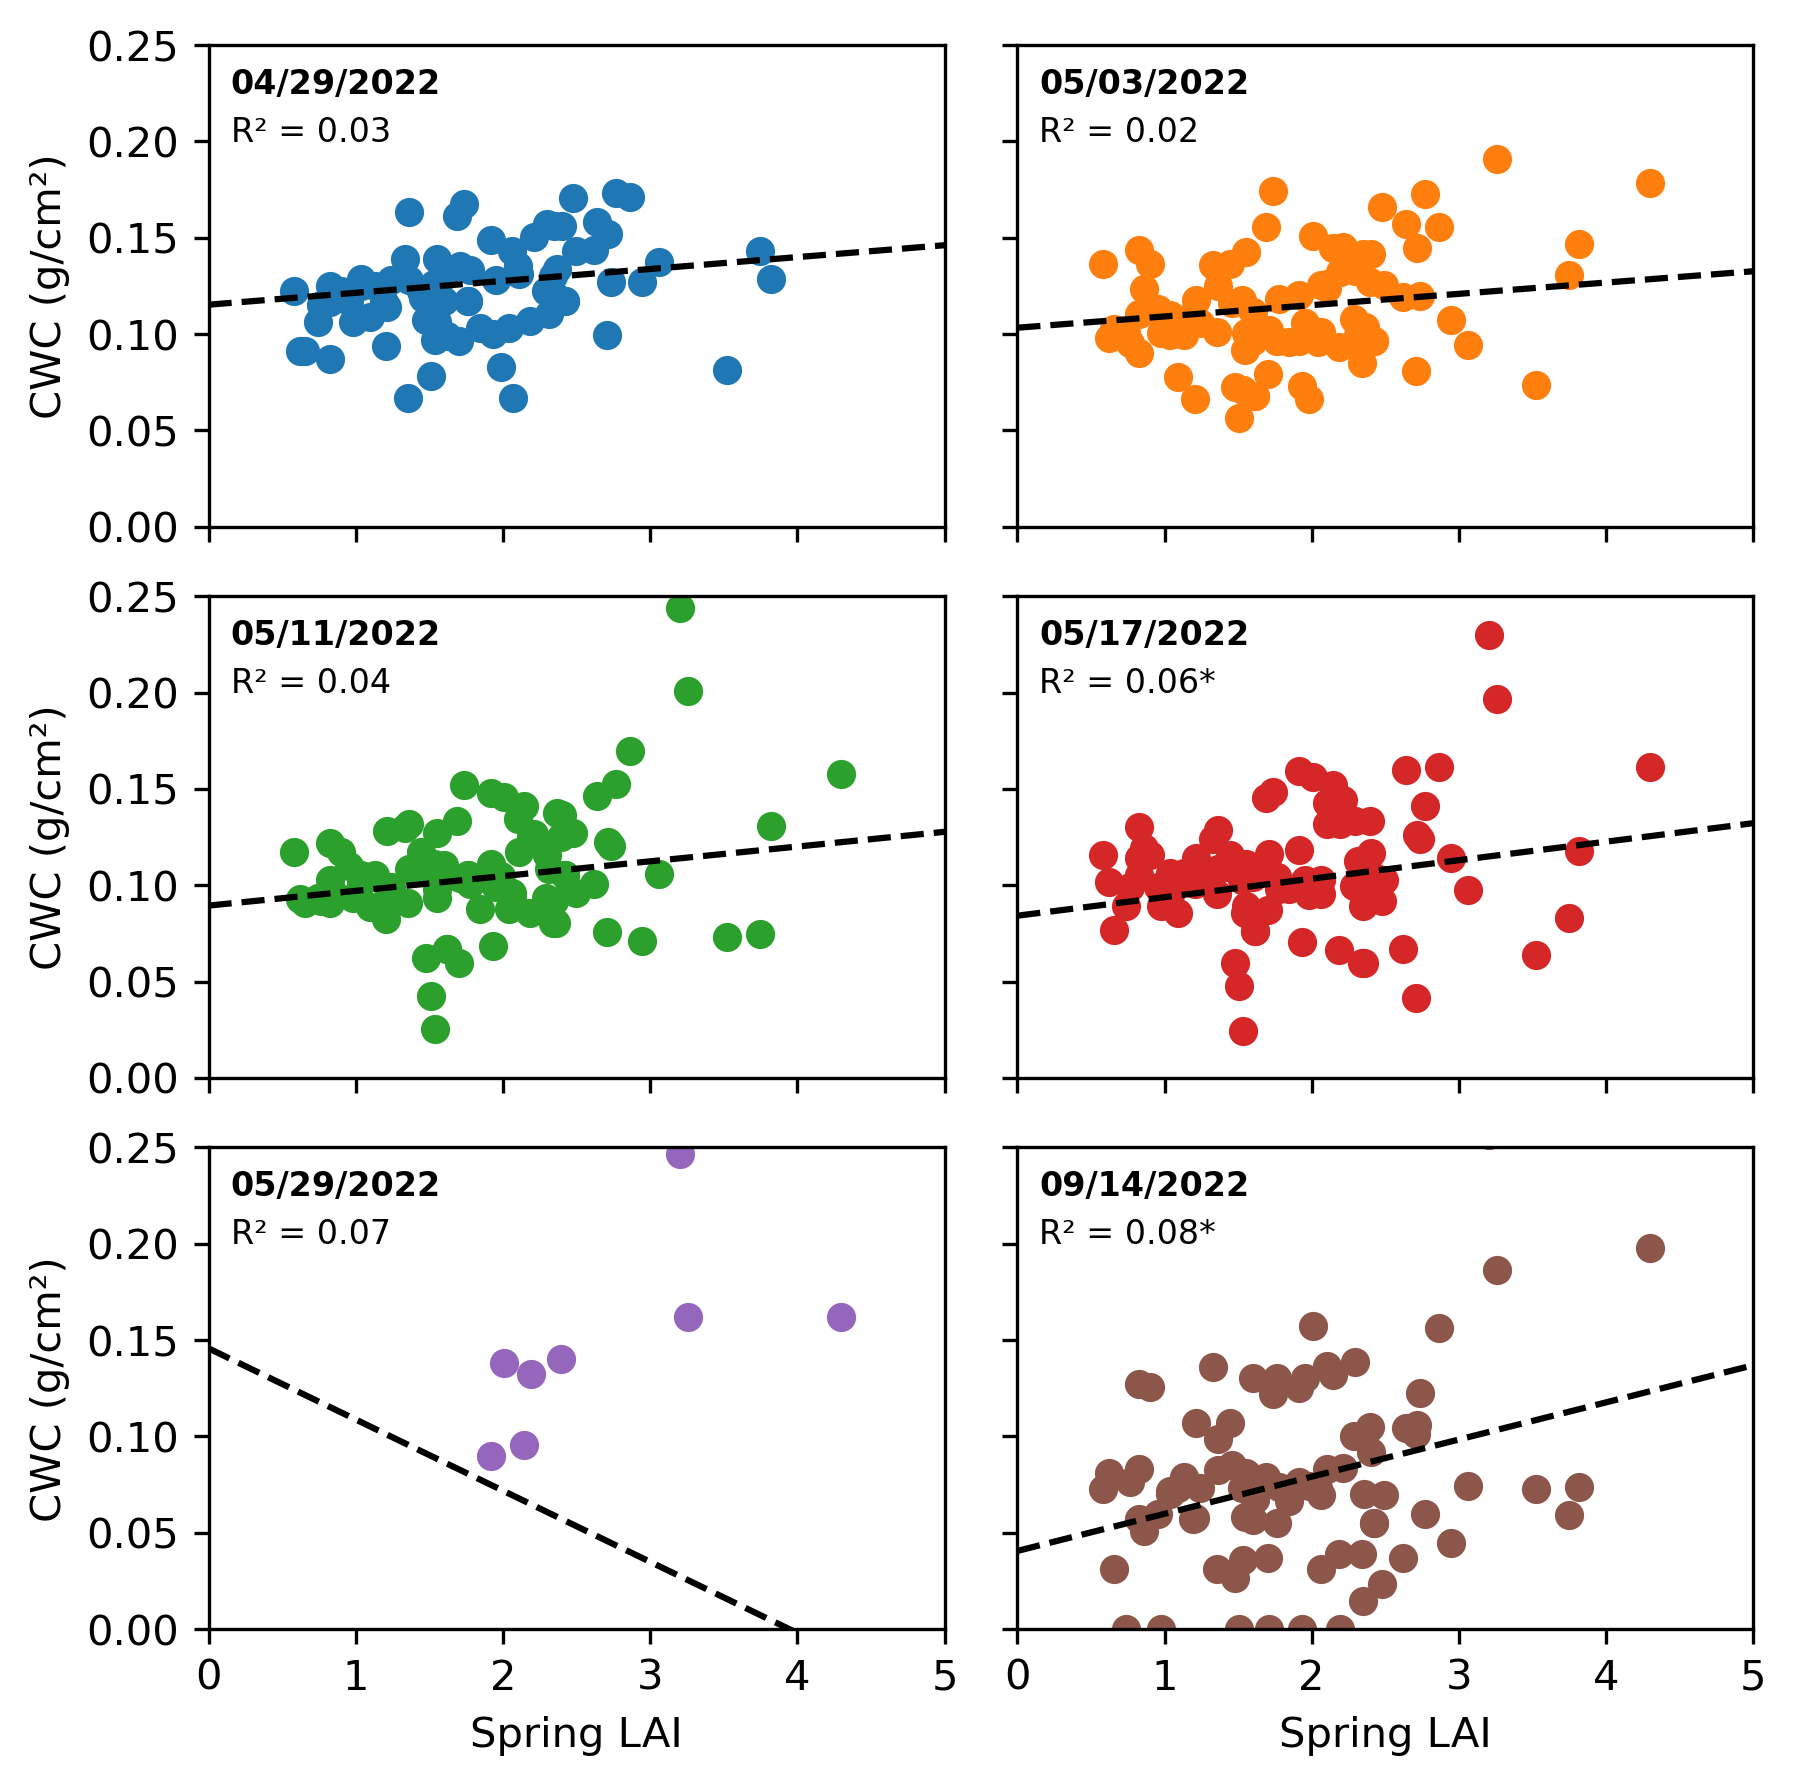

In [71]:
## separated out by date...

fig, axs = plt.subplots(3, 2, figsize=(6, 6), sharex=True, sharey=True)

for ax, cwc_df, date, color in zip(axs.flatten(), cwc_df_list, datetime_list, color_list):
    ax.scatter(cwc_df['septlai'], cwc_df['CWC'], color=color)

    # linear regression
    slope, intercept, r_value, p_value, std_err = linregress(cwc_df[['winterlai', 'CWC']].dropna())
    x = np.linspace(0, 5, 100)
    y = slope * x + intercept
    ax.plot(x, y, color='black', linestyle='--')
    
    ax.text(0.03, 0.9, date.strftime('%m/%d/%Y'), transform=ax.transAxes, fontsize=8, weight='bold')
    r2_str = 'R² = ' + str(round(r_value**2, 2))
    if p_value < 0.05:
        r2_str += '*'
    if p_value < 0.01:
        r2_str += '*'
    ax.text(0.03, 0.8, r2_str, transform=ax.transAxes, fontsize=8)
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 0.25)

    if ax in axs[2, :]:
        ax.set_xlabel('Spring LAI')
    if ax in axs[:, 0]:
        ax.set_ylabel('CWC (g/cm²)')

plt.tight_layout()
plt.savefig('./LAI_CWC_scatter.png')